<a href="https://colab.research.google.com/github/SebastianJanampa/SOFI/blob/main/online_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Aug 27 21:34:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ON-LINE demo for SOFI

Hi 😀. This is the official notebook to use SOFI.

Here, you will find info about:


1.   Installation
2.   How to call and use SOFI

**Notes:**
*   We currently support only SOFI model.
*   We require GPU to execute the SOFI.
*   Change your runtime type to GPU.


## Installation

In the moment of installing the *MultiScaleDeformableAttention* module, you will observe many warnings.

Simply ignore them.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
%cd {HOME}
!git clone https://github.com/SebastianJanampa/SOFI.git
%cd {HOME}/SOFI

/content
fatal: destination path 'SOFI' already exists and is not an empty directory.
/content/SOFI


In [5]:
!pip install pylsd-nova==1.2.1

In [7]:
%cd models/sofi/ops
!python setup.py build install
# unit test (should see all checking is True)
# !python test.py # optional
%cd ../../..

/content/SOFI/models/sofi/ops
running build
running build_py
copying modules/__init__.py -> build/lib.linux-x86_64-cpython-310/modules
copying modules/ms_deform_attn.py -> build/lib.linux-x86_64-cpython-310/modules
copying functions/ms_deform_attn_func.py -> build/lib.linux-x86_64-cpython-310/functions
copying functions/__init__.py -> build/lib.linux-x86_64-cpython-310/functions
running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:495: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:414: UserWarning: The detected CUDA version (12.2) has a minor version mismatch with the version that was used to compile PyTorch (12.1). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cu

Before moving forward, restart the session. **Do not DISCONNECT**

## Run model
We cover:
* Loading an image and pre-processing
* Downloading and loading model weights

In [ ]:
# Download weights
!wget -O sofi.pth https://www.dropbox.com/scl/fi/1dwdn9sepyyj818ri5ml9/sofi.pth?rlkey=zwldsnj0vk7tb8px4hid2xwf8&st=s7uq8s2n&dl=0

In [8]:
import cv2
import torchvision.transforms.functional as F
import torch

def load_image(image_path):
  image = cv2.imread(image_path)
  assert image is not None, print(image_path)
  image = image[:,:,::-1] # convert to rgb

  org_h, org_w = image.shape[0], image.shape[1]
  image = cv2.resize(image, dsize=(512, 512))

  image = F.to_tensor(image)
  image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  extras={'lines': torch.zeros((1, 512, 3), device='cuda'),
          'line_mask': torch.ones((1, 512, 1), device='cuda'),
          'segs': torch.zeros((1, 512, 4), device='cuda')}
  return image[None].to('cuda'), extras

In [9]:
from configs.sofi import sofi
checkpoint = torch.load('sofi.pth', map_location='cpu')
model = sofi
model.load_state_dict(checkpoint['model'], strict=True)
model = model.to('cuda')
model.eval()

image_path = 'samples/sample1.jpg'
image, extras = load_image(image_path)

with torch.no_grad():
  output = model(image, extras)

## Visualization of the Horizon Line

(-320.0, 320.0, 320.0, -320.0)

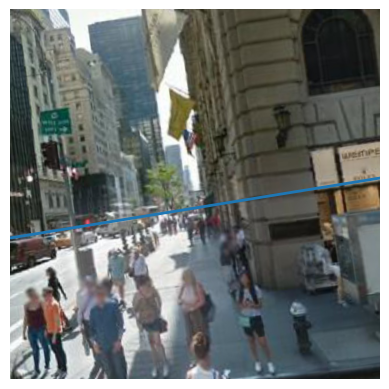

In [10]:
import numpy as np
import matplotlib.pyplot as plt
def compute_hl_np(hl, sz, eps=1e-6):
    (a,b,c) = hl
    if b < 0:
        a, b, c = -a, -b, -c
    b = np.maximum(b, eps)

    left = np.array([-1.0, (a - c)/b])
    right = np.array([1.0, (-a - c)/b])

    # scale back to original image
    scale = sz[1]/2
    left = scale*left
    right = scale*right
    return [np.squeeze(left), np.squeeze(right)]

img = cv2.imread(image_path)
img = img[:,:,::-1] # convert to rgb
img_sz = img.shape

pred_hl = output['pred_hl'].to('cpu')[0].numpy()
pred_hl_pts = compute_hl_np(pred_hl, img_sz)

plt.imshow(img, extent=[-img_sz[1]/2, img_sz[1]/2, img_sz[0]/2, -img_sz[0]/2])
plt.plot([pred_hl_pts[0][0], pred_hl_pts[1][0]],
          [pred_hl_pts[0][1], pred_hl_pts[1][1]], linewidth=2)
plt.axis('off')